In [1]:
import matplotlib
import matplotlib.pyplot as plt
# import pandas as pd

import numpy as np
from scipy.integrate import solve_ivp
import time

import gymnasium as gym
from gymnasium import spaces
import stable_baselines3 as sb

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_checker import check_env

In [2]:
patm        = 98000     # Pascals
T_amb       = 293       # Kelvin
# nR          = 800e-8   # n (moles) * R (cte gases)
N           = 6e15      # Num Particulas
kb          = 1.38e-23  # J/K

rho_agua    = 1000      # kg/m^3
viscosidad  = 0.001      # Pa*s == kg/s
s_sup       = 7e-2  # N/m

# Presion acustica como la suma de varias ondas
def ps(t, A, w, d = 0):
    # Error Handling es mi pasion
    assert len(A) == len(w) == len(d), "Different shapes"
    r = 0
    for i in range(len(A)):
        r += A[i] * np.sin(t*w[i] + d[i])  
    return r
"""
Probablemente sea importante, cambie el orden de las cosas
(RDot,R,T) ==> (R,RDot,T) 
"""
# DiffEqs
def fun(t, y, ps_args):
    radi, vel, temp = y
    vDot = (
                - 3/2 * np.power(vel,2)
                + (
                    3/4 * N*kb*temp/(np.pi*np.power(radi,3))
                    - (2*s_sup+4*viscosidad*vel)/radi
                    - patm
                    - ps(t, *ps_args)
                )/rho_agua
            )/radi
    rDot = vel
    tDot = - 2 * temp * vel/radi

    return rDot, vDot, tDot   

In [3]:
'''
Normalized (as much as I can) observations
El observation space lo voy a hacer un poco mas grande para q tenga margen
    Radio always positive in the 1e-3 order  ==>  *100 to scale up
    Vel has high range ==> /1000 to scale down a little
    Temp in logaritmic scale ==> between ~0 and 7
'''
def observations(R,RDot,T):
    return np.array([R*100, RDot/1000, np.log10(T)]).astype(np.float32)

In [12]:
class Bubble(gym.Env):
    """
    Custom Environment that follows gym interface.
    This is a simple env where the agent must learn to go always left. 
    """
    metadata = {'render.modes': ['data','plot']}

    def __init__(self, time_limit = 0.1, dt = 1e-5, n_ondas = 1, render_mode = None):
        super(Bubble, self).__init__()   

        # (R,RDot,T)
        self.agent_vars = (np.clip(np.random.normal(1e-3, 1e-4), 0,     1),
                           np.clip(np.random.normal(0,1)       , -1e3,  1e3),
                           np.clip(np.random.normal(T_amb, 10), 250,    350))

        # variables de tiempo
        self.time_limit = time_limit
        self.t  = 0
        self.dt = dt  # timestep en seg

        '''
        Actions: cambios de Amplitud,frecuencia y fase
        - van a ir entre 0 y 1, dsp en el step les hago el correcto escaleo
        '''
        self.action_space = spaces.Box(low = 0, high = 1,
                                        shape=(3, n_ondas), dtype=np.float32)
        self.n_ondas = n_ondas
        '''
        Observations: Basicamente R,RDot,T
        - Si hago los cambios de a pasos tendria que añadir los valores actuales de A,w,d
        '''
        self.observation_space = spaces.Box(low = np.array((0,-100,0)),
                                            high = np.array((10, 100,10)),
                                            shape=(3,), dtype=np.float32)
        
        '''
        Render init Cosas
        '''
        self.render_mode = render_mode
        if render_mode != None:
            self.data = {"t":np.array([]),
                        "y":np.array([[],[],[]]),
                        "actions":np.array([[[0]*n_ondas,[0]*n_ondas,[0]*n_ondas]])}


    def reset(self, seed = 0):
        super().reset(seed=seed)

        # Nuevas Cond Iniciales
        self.agent_vars = (np.clip(np.random.normal(1e-3, 1e-4), 0,     1),
                           np.clip(np.random.normal(0,1)       , -1e3,  1e3),
                           np.clip(np.random.normal(T_amb, 10), 250,    350))
        # Render reset cosas
        if self.render_mode != None:
            self.data = {"t":np.array([]),
                        "y":np.array([[],[],[]]),
                        "actions":np.array([[[0]*self.n_ondas,[0]*self.n_ondas,[0]*self.n_ondas]])}
        
        return observations(*np.ravel(self.agent_vars)), {}
    
    def step(self, action):

        # Check action range (if stepped) ----------------------------------- ARAARA
        if any([(a>1)or(a<0) for a in np.ravel(action)]):
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))
        else:
            A = action[0] * (20*patm)
            w = action[1] * (np.pi * 2e6)
            d = action[2] * (2*np.pi)
            # print(A,'\n',w,'\n',d)

        sol = solve_ivp(fun, (self.t, self.t + self.dt), 
                        self.agent_vars, args = [[A,w,d]]
                        , max_step = self.dt/10, rtol = 1e-12)
        
        # Error Handling es mi pasion
        if not sol["success"]:
            print("Has been a problem with solve_ivp")
            print(sol["message"])
            return

        # La AI solo necesita el ultimo dato pero esta todo por si se quisiera graficar
        self.agent_vars = sol.y[:,-1] 
        # time++
        self.t += self.dt

        if self.render_mode != None:
            self.data['t'] = np.concatenate((self.data['t'],sol.t))
            self.data['y'] = np.concatenate((self.data['y'],sol.y), 1)
            self.data['actions'] = np.concatenate((self.data['actions'],[[A,w,d]]))
        
        ''' [ ] Reward '''
        reward = np.log10(self.agent_vars[2])
        
        # Additional info
        ''' [ ] Hypothesis checking '''
        info = {}

        if self.t >= self.time_limit:
            info["Truncated"] = True# "End of Episode"
            return observations(*np.ravel(self.agent_vars)),\
                    reward, False, True, info
        else:
            return observations(*np.ravel(self.agent_vars)),\
                    reward, False, False, info

    def render(self, seed = 0):
        if self.render_mode == 'data':
            return self.data
        elif self.render_mode == 'plot':
            raise NotImplementedError()
        else:
            raise NotImplementedError()

    def close(self):
        pass

In [13]:
env = Bubble(n_ondas=2)
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

c:\ProgramData\anaconda3\envs\Inv1\Lib\site-packages\stable_baselines3\common\env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [14]:
model = sb.PPO('MlpPolicy', env,
               n_steps = 1024, batch_size = 64)

In [18]:
model.learn(total_timesteps = int(1e5))

In [21]:
model.n_steps, model.n_epochs

(1024, 10)

In [19]:
single_env = Bubble(n_ondas=2, render_mode = 'data')
obs, _ = single_env.reset()
        
for step in range(20000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = single_env.step(action)
    #print("Step {}".format(step + 1), "\t", "Action: ", action, "\t", "reward=", reward)
    if terminated or truncated:
        # Note that the VecEnv resets automatically
        # when a done signal is encountered
        print(step+1, info)
        break

data = single_env.render()

c:\ProgramData\anaconda3\envs\Inv1\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


10001 {'Truncated': True}


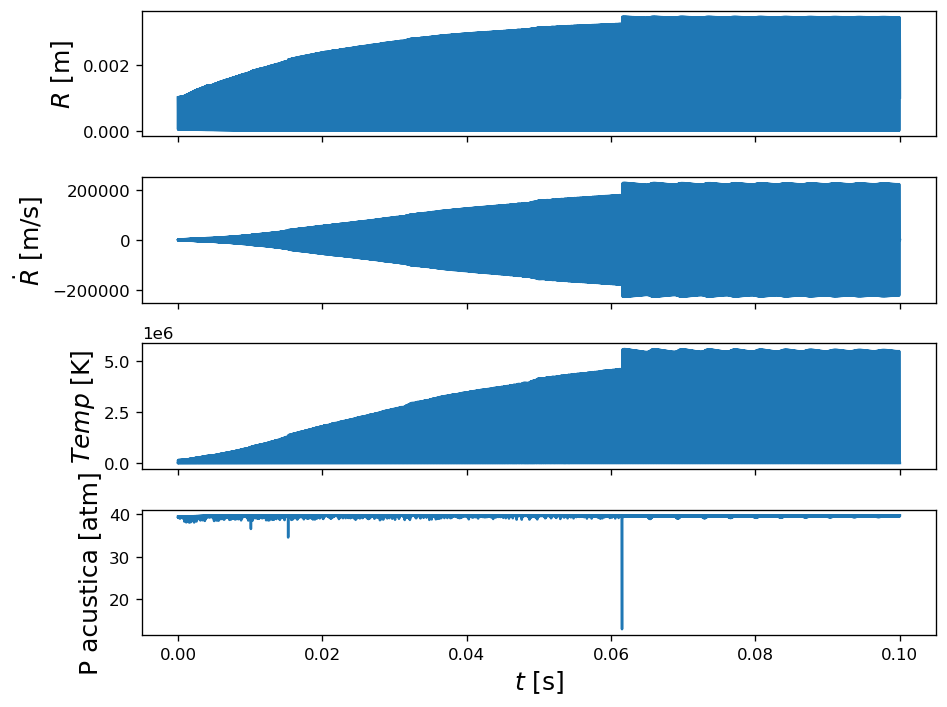

In [20]:
matplotlib.rcParams['axes.labelsize'] = 15
variables = [r"$R$ [m]", r"$\dot R$ [m/s]", r"$Temp$ [K]"]

fig, ax = plt.subplots(4, sharex= True, figsize = (8,6), dpi = 120, tight_layout = True)

for i in range(3):
    ax[i].plot(data['t'], data['y'][i])
    ax[i].set_ylabel(variables[i])

ax[-1].set_xlabel("$t$ [s]")

dt = 1e-5
t =  [np.linspace((i-1)*dt, i*dt, 100) for i in range(1,len(data['actions']))]
psdots = [ps(t[i-1], *data['actions'][i]) for i in range(1,len(data['actions']))]

ax[3].set_ylabel(r"P acustica [atm]")
ax[3].plot(np.ravel(t), np.ravel(psdots)/patm)